# Apprendimento per rinforzo

In questa sezione delle dispense abbiamo esaminato il modello di regressione. Sebbene il modello di regressione sia estremamente popolare in psicologia e nelle scienze sociali, presenta dei limiti sostanziali. È utile per descrivere le associazioni tra variabili, ma non è adatto per scoprire nessi causali, che rappresentano l'obiettivo principale delle teorie scientifiche. Come afferma Richard McElreath: "Le persone una volta facevano teoria. Ora fanno solo regressioni".

Trovare associazioni nei dati osservazionali non è un buon metodo per costruire teorie. Abbiamo bisogno di una motivazione per esaminare determinate variabili, poiché le associazioni tra variabili non sono rare, ma raramente sono causali. Il fatto che nessuno abbia esaminato l'associazione tra certe variabili in precedenza non è un buon motivo per farlo in un nuovo progetto di ricerca.

Un approccio preferibile, che una volta era comune, è utilizzare una teoria formale per sviluppare aspettative sui dati osservati, misurare le variabili corrette e utilizzare modelli statistici specifici per testare la teoria, non solo regressioni.

In questo capitolo, forniremo un esempio di questo approccio implementando un modello che rappresenta un processo cognitivo sottostante, piuttosto che limitarsi a descrivere le associazioni tra variabili. Nello specifico, esamineremo uno dei modelli psicologici più influenti: il modello di apprendimento di Rescorla-Wagner. Analizzeremo la definizione del modello, il significato dei suoi parametri e i metodi per stimarli dai dati osservati, con particolare attenzione all'uso della massima verosimiglianza e del software Stan.

Il presente tutorial trae ispirazione dall'articolo di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547) e utilizza il codice fornito da [Rhoads, S. A. & Gan, L. (2022)](https://shawnrhoads.github.io/gu-psyc-347/index.html).

In [3]:
%run ../_config/config.py # Import the configuration settings
import logging
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize  # finding optimal params in models
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

## L'apprendimento per rinforzo: imparare dall'esperienza

Immagina un robot alle prese con un videogioco, privo di istruzioni precise ma con un obiettivo ben chiaro: ottenere il punteggio più alto. Attraverso tentativi ed errori, il robot sperimenta diverse azioni, scoprendo quali lo avvicinano al successo e quali no. Questo è il principio fondamentale dell'apprendimento per rinforzo (RL), un metodo di intelligenza artificiale ispirato al modo in cui gli esseri viventi imparano.

### Il meccanismo alla base dell'apprendimento per rinforzo

Nell'apprendimento per rinforzo, un "agente" (che sia un robot, un modello matematico o una persona) interagisce con un "ambiente". L'agente compie azioni e riceve in cambio "ricompense" positive o negative, a seconda di quanto le sue azioni sono vicine al raggiungimento del suo obiettivo. L'obiettivo dell'agente è imparare a scegliere le azioni che gli permetteranno di ottenere il maggior numero di ricompense positive nel tempo.

### Esplorazione e sfruttamento

Uno dei dilemmi principali che gli agenti di apprendimento per rinforzo si trovano ad affrontare è il bilanciamento tra esplorazione e sfruttamento. Da un lato, l'agente ha bisogno di esplorare l'ambiente, provare nuove azioni e scoprire nuove strategie per ottenere ricompense. Dall'altro lato, desidera anche sfruttare la conoscenza già acquisita, scegliendo le azioni che ha già scoperto essere efficaci in passato.

### L'apprendimento per rinforzo nella ricerca sull'intelligenza artificiale

Dalla fine degli anni '60, molti ricercatori nel campo dell'intelligenza artificiale hanno ipotizzato che non esistano principi generali da scoprire, e che l'intelligenza derivi piuttosto dalla conoscenza di un vasto numero di trucchi, procedure ed euristiche specializzati. L'intelligenza artificiale moderna dedica invece molta attenzione alla ricerca di principi generali di apprendimento e processo decisionale. In questo senso, la ricerca sull'apprendimento per rinforzo rappresenta sicuramente un ritorno verso principi di intelligenza artificiale più semplici e universali.

## Un esempio pratico: il problema dei two-armed bandits

Immaginiamo un giocatore di fronte a due slot machine. Ogni volta che sceglie una slot, può vincere (ottenendo un premio) o perdere (non ottenendo nulla). La probabilità di vincita varia tra le due slot machine, ma il giocatore non le conosce all'inizio. Il suo obiettivo è massimizzare le vincite scegliendo la slot machine con la maggiore probabilità di vincita il più spesso possibile.

Questo semplice problema illustra il dilemma fondamentale dell'apprendimento per rinforzo: esplorare entrambe le slot machine per scoprire quale è la migliore (esplorazione) o sfruttare la slot machine che ha già scoperto essere la più vincente (sfruttamento)?

Il modello di apprendimento di Rescorla-Wagner affronta proprio questo problema del "two-armed bandits". In questo scenario, un partecipante deve compiere ripetutamente delle scelte tra due opzioni o azioni. Dopo ogni scelta, riceve una ricompensa numerica estratta da una distribuzione di probabilità che dipende dall'azione selezionata. L'obiettivo del partecipante è massimizzare la ricompensa totale attesa durante un certo periodo di tempo, ad esempio, durante 100 scelte.

Una metafora comune per descrivere questa situazione è quella di un giocatore che deve fare una serie di scelte tra due slot machine ("two-armed bandits") per massimizzare le sue vincite. Se nella scelta $t$ viene selezionata la slot machine $k$, il partecipante ottiene una ricompensa $r_t$. Questa ricompensa ha valore `1` con una probabilità di successo $ \mu^k_t $ specifica per quella slot machine, altrimenti ha valore `0`.

In altre parole:

- Ogni volta che il partecipante sceglie una slot machine, può vincere (ottenendo una ricompensa di `1`) o perdere (ottenendo una ricompensa di `0`).
- La probabilità di vincita varia tra le due diverse slot machine.
- Queste probabilità di successo sono inizialmente sconosciute al partecipante.

Nella versione più semplice di questo problema, le probabilità di successo $ \mu^k_t $ rimangono costanti nel tempo. Questo significa che la probabilità di vincere su una determinata slot machine non cambia durante il periodo di osservazione.

## Simulare l'Apprendimento

Nel problema del two-armed bandit, ogni azione (cioè la scelta di una specifica slot machine) ha un valore associato che rappresenta la ricompensa attesa quando quella specifica azione viene selezionata. Questo valore è chiamato "valore dell'azione". Conoscendo il valore di ogni azione, il problema di apprendimento si riduce a scegliere sempre l'azione con il valore più alto per massimizzare la ricompensa totale.

### Parametri del Problema

Per simulare il problema, dobbiamo considerare tre parametri principali:
1. **Il numero di tentativi, $ T $**: Questo rappresenta quante volte il partecipante farà una scelta. Ad esempio, se $ T = 100 $, il partecipante farà 100 scelte.
2. **Il numero di slot machine, $ K $**: Questo indica quante opzioni di scelta sono disponibili. Ad esempio, se $ K = 2 $, ci sono due slot machine tra cui scegliere.
3. **Le probabilità di ricompensa delle diverse opzioni, $ \mu^k_t $**: Queste sono le probabilità che ogni slot machine offra una ricompensa. Queste probabilità possono variare nel tempo, ma nella versione più semplice del problema, rimangono costanti.

### Esempio Pratico

In questo tutorial, simuleremo il comportamento di un partecipante che sceglie tra due slot machine, utilizzando il modello di apprendimento di Rescorla-Wagner. Ecco come configureremo la simulazione:
- Imposteremo il numero di tentativi a $ T = 100 $. Questo significa che il partecipante farà 100 scelte.
- Imposteremo il numero di slot machine a $ K = 2 $. Ci saranno quindi due slot machine tra cui scegliere.
- Imposteremo le probabilità di ricompensa delle slot machine a $ \mu = [0.2, 0.8] $. Questo significa che la slot machine 1 ha una probabilità del 20% di offrire una ricompensa, mentre la slot machine 2 ha una probabilità dell'80% di offrire una ricompensa.

Ogni azione ha un valore che rappresenta la ricompensa attesa. In altre parole, il valore dell'azione è la media delle ricompense che ci si aspetta di ottenere scegliendo quella particolare azione. Se si conosce questo valore per ogni azione, il partecipante dovrebbe sempre scegliere l'azione con il valore più alto per massimizzare le sue ricompense.

L'obiettivo di questo tutorial è mostrare come si può simulare il processo di apprendimento e come si possono usare modelli come quello di Rescorla-Wagner per capire meglio come le persone prendono decisioni in situazioni di incertezza. Attraverso la simulazione, vedremo come il partecipante può apprendere e adattarsi alle probabilità di ricompensa delle slot machine per massimizzare le sue vincite nel corso del tempo.

## Imparare il rinforzo: i componenti chiave

L'apprendimento per rinforzo è simile a come gli esseri viventi imparano attraverso l'esperienza: provando e sbagliando, imparano ad associare le loro azioni a conseguenze positive o negative.

Per comprendere meglio il funzionamento dell'apprendimento per rinforzo, è fondamentale analizzare i suoi quattro componenti chiave.

**1. La politica (o strategia)**

Il robot non agisce a caso. Ha una strategia, un piano d'azione che cambia nel tempo in base ai risultati ottenuti. Inizialmente, potrebbe scegliere le slot casualmente (50% leva A, 50% leva B). Ma con l'esperienza, impara a preferire la leva che gli ha dato più vincite.

In termini tecnici, la strategia è rappresentata dalla funzione **π (pi)**, che associa le azioni possibili (tirare la leva A o B) ai diversi stati del gioco (vincita, perdita). All'inizio, **π** potrebbe essere casuale. Ma con il tempo, si aggiorna in base alle ricompense ricevute, aumentando la probabilità di scegliere la leva vincente.

**2. La ricompensa**

La ricompensa è un segnale che indica all'agente la bontà o meno delle sue azioni. La ricompensa può essere positiva (rinforzo) se l'azione è stata vantaggiosa, o negativa (punizione) se l'azione è stata dannosa. L'obiettivo dell'agente è massimizzare la ricompensa cumulativa nel lungo periodo.

In termini tecnici, la funzione di ricompensa **R** assegna un valore numerico a ogni stato del gioco: 1 per la vincita e 0 per la perdita. Il robot è "motivato" a massimizzare la **ricompensa cumulativa**, ovvero la somma totale delle vincite ottenute nel tempo.

**3. La funzione di valore**

Per ogni leva, il robot calcola la ricompensa media che si aspetta di ricevere in futuro. In altre parole, cerca di capire quale slot è più "generosa" nel lungo periodo.

In termini tecnici, la funzione di valore **Q** stima la ricompensa media attesa per ogni stato del gioco. Il robot utilizza questa stima per scegliere l'azione che lo porterà nello stato con il valore **Q** più alto, ovvero la slot machine che ha maggiori probabilità di fargli ottenere una vincita nel lungo periodo.

**4. Il modello dell'ambiente**

In alcuni casi, il robot può avere un asso nella manica: un **modello dell'ambiente**, ovvero una simulazione dell'ambiente che permette all'agente di prevedere le conseguenze delle sue azioni prima di compierle.

In termini tecnici, il modello dell'ambiente **M** è una simulazione delle slot machine che permette al robot di prevedere la probabilità di vincita per ogni leva. Il robot può utilizzare questa informazione per aggiornare la sua funzione di valore e scegliere l'azione che massimizza la ricompensa attesa.


## Modello di Apprenimento di Rescorla-Wagner

Il modello di apprendimento di Rescorla-Wagner, sviluppato per comprendere come gli esseri viventi apprendono le associazioni tra eventi, è particolarmente utile nel descrivere l'apprendimento associativo, come il condizionamento classico. Il modello si basa sull'idea che l'apprendimento avvenga attraverso l'aggiornamento continuo delle aspettative sulla base degli **errori di previsione**. In altre parole, la differenza tra ciò che ci si aspetta di ricevere e ciò che viene effettivamente osservato determina come modifichiamo le nostre aspettative per il futuro.

### Aspettativa di Valore

Immaginiamo un problema con **due bandit a due braccia**: ogni braccio rappresenta un'azione con una specifica ricompensa media associata. Il valore di un'azione corrisponde alla sua ricompensa media attesa. 

Indichiamo con:

- $A_t$: l'azione scelta al tempo $t$;
- $R_t$: la ricompensa ottenuta dopo aver scelto l'azione $A_t$;
- $q^{*}(a)$: il valore atteso dell'azione $a$ (ovvero la ricompensa media attesa se scegliamo $a$).

Se conoscessimo il valore esatto di ogni azione, il problema del bandit a due braccia sarebbe banale: basterebbe scegliere sempre l'azione con il valore più alto. Tuttavia, in realtà, non conosciamo con certezza i valori delle azioni, ma possiamo solo stimarli. 

Indichiamo con $Q_t(a)$ la stima del valore dell'azione $a$ al tempo **t**. L'obiettivo è far sì che $Q_t(a)$ si avvicini il più possibile al valore reale $q^{*}(a)$.

### La Regola di Apprendimento

Secondo il modello Rescorla-Wagner, il valore atteso di un'azione viene aggiornato dopo ogni tentativo usando la seguente regola:

$$Q_k(t + 1) = Q_k(t) + \alpha (R_k - Q_k(t))$$

dove:

- $Q_k(t)$: valore atteso dell'azione **k** al tempo **t**
- $\alpha$: **tasso di apprendimento**, un valore compreso tra 0 e 1 che determina la velocità di aggiornamento delle aspettative. Un valore più alto di **α** implica un apprendimento più rapido, mentre uno più basso implica un apprendimento più lento.
- $R_k$: ricompensa ottenuta dopo aver scelto l'azione **k** al tempo **t**
- $R_k - Q_k(t)$: **errore di previsione**, la differenza tra la ricompensa ottenuta e quella attesa

In parole semplici, l'errore di previsione guida l'aggiornamento delle nostre aspettative: se la ricompensa è maggiore del previsto, il valore dell'azione viene aumentato; se la ricompensa è minore del previsto, il valore dell'azione viene diminuito.

### La Regola Decisionale

Per decidere quale azione intraprendere, utilizziamo la regola **softmax**, che bilancia l'esplorazione di nuove opzioni con la scelta dell'azione con il valore atteso più alto. La regola softmax trasforma i valori attesi **Q** in probabilità di scelta:

$$p_k(t) = \frac{exp(\theta Q_k(t))}{\sum_{i=1}^K exp(\theta Q_i(t))}$$

dove:

- $p_k(t)$: probabilità di scegliere l'azione **k** al tempo **t**
- $\theta$: parametro **temperatura** che controlla il livello di esplorazione. Valori alti di $\theta$ portano a scelte più deterministiche (quasi sempre l'azione con il valore più alto), mentre valori bassi portano a scelte più casuali.

#### Esempio di Calcolo della Softmax

Per capire come funziona la softmax, consideriamo alcuni valori di $Q$ e $\theta$.

In [4]:
def softmax(Q, theta):
    p = np.exp(theta * Q) / np.sum(np.exp(theta * Q))
    return p

Q = np.array([0.25, 0.75])
theta = 3.5
print(softmax(Q, theta))

[0.1480472 0.8519528]


In [5]:
theta = 0.5
print(softmax(Q, theta))

[0.4378235 0.5621765]


La funzione softmax trasforma i valori $Q$ e $\theta$ in una distribuzione di probabilità, mostrando come la probabilità di scelta cambia al variare di $\theta$.

### Variazione di $\theta$ con Valori Fissi di $Q$

Manteniamo fissi i valori di $Q$ e facciamo variare $\theta$:

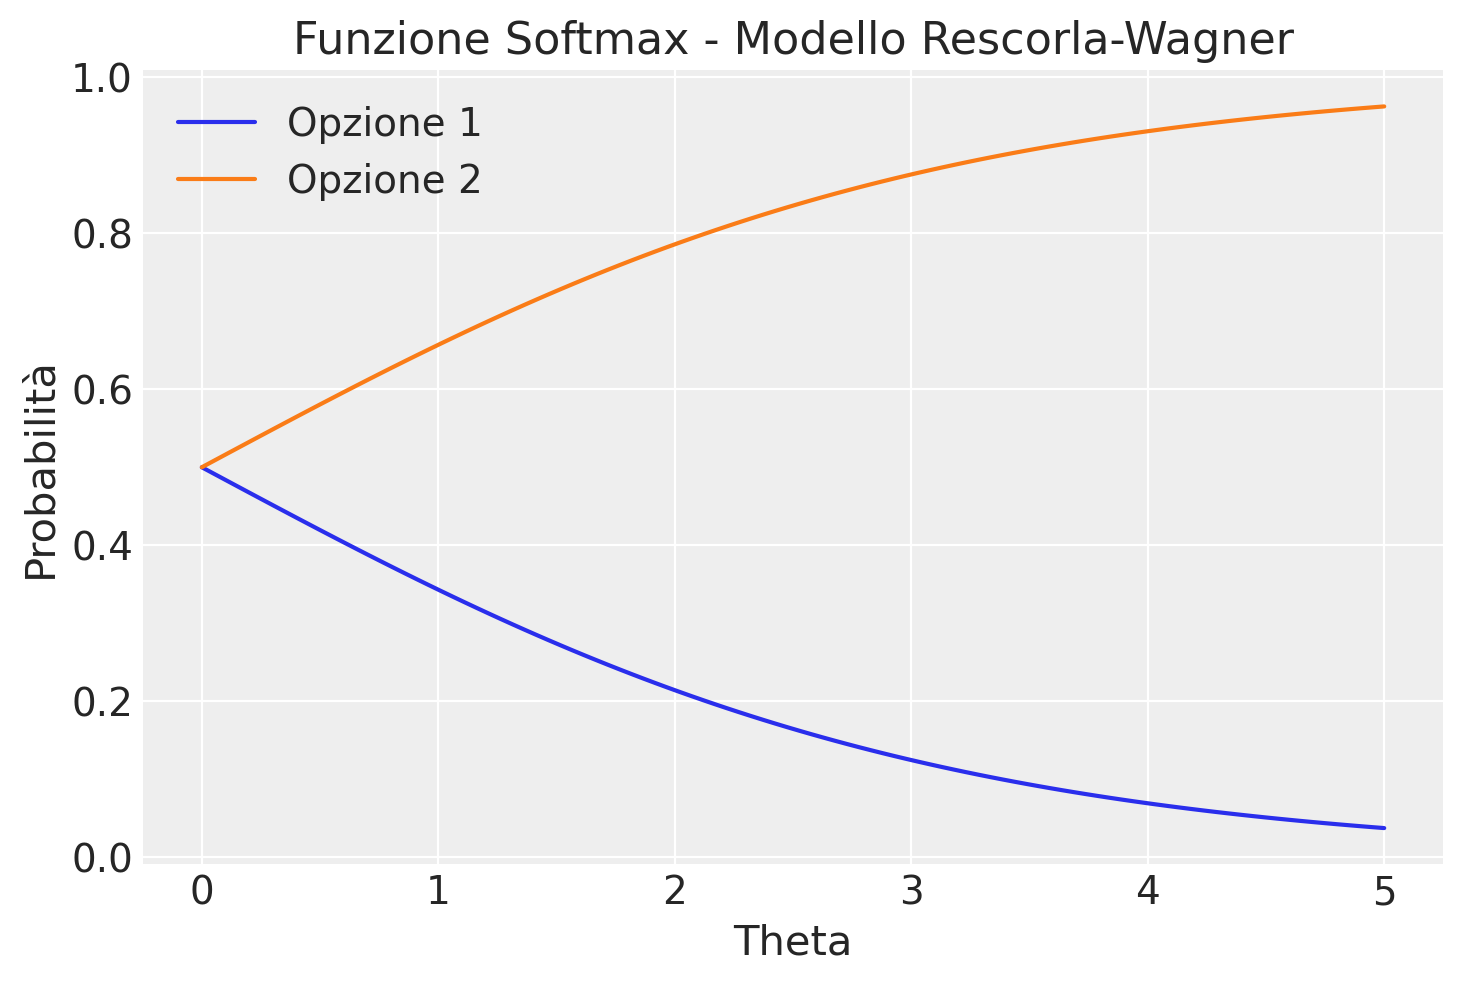

In [6]:
Q = np.array([0.1, 0.75])
theta_values = np.linspace(0, 5, 100)

probabilities_list = []
for theta in theta_values:
    probabilities = softmax(Q, theta)
    probabilities_list.append(probabilities)
    
probabilities_array = np.array(probabilities_list).T

option_labels = ['Opzione 1', 'Opzione 2']

plt.figure()
for i in range(len(option_labels)):
    plt.plot(theta_values, probabilities_array[i], label=option_labels[i])

plt.xlabel('Theta')
plt.ylabel('Probabilità')
plt.title('Funzione Softmax - Modello Rescorla-Wagner')
plt.legend()
plt.grid(True)
plt.show()

Il grafico risultante mostra come le probabilità di scelta cambiano al variare del parametro $\theta$. Quando $\theta$ è vicino a zero, la scelta è quasi casuale. Quando $\theta$ è molto grande, la scelta è quasi sempre l'opzione con il valore più alto.

## Simulazione del Modello di Rescorla-Wagner

Combiniamo la regola di apprendimento e la regola decisionale per simulare il comportamento del partecipante:

In [7]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params
    
    # Un array di zeri di lunghezza T
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    Q_stored = np.zeros((2, T), dtype=float)
    
    # Inizializza Q per t == 0
    Q = [0.5, 0.5]

    for t in range(T):

        # Salva i valori Q per Q_{t+1}
        Q_stored[:, t] = Q

        # Calcola le probabilità di scelta
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # Se noisy_choice è vero, viene simulato un comportamento di scelta rumoroso in 
        # cui l'opzione 0 è scelta con probabilità p0, mentre l'opzione 1 è scelta con 
        # probabilità 1-p0.
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else:  # la scelta viene effettuata senza rumore
            c[t] = np.argmax([p0, p1])

        # Genera la ricompensa sulla base delle probabilità di ricompensa
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored


Simuliamo `T` = 100 prove utilizzando il modello generativo dei dati definito in precedenza.

In [8]:
T = 100
K = 2
mu = [0.2, 0.8]

In [9]:
c, r, Q = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)

Rappresentiamo graficamente i risultati ottenuti dalla simulazione.

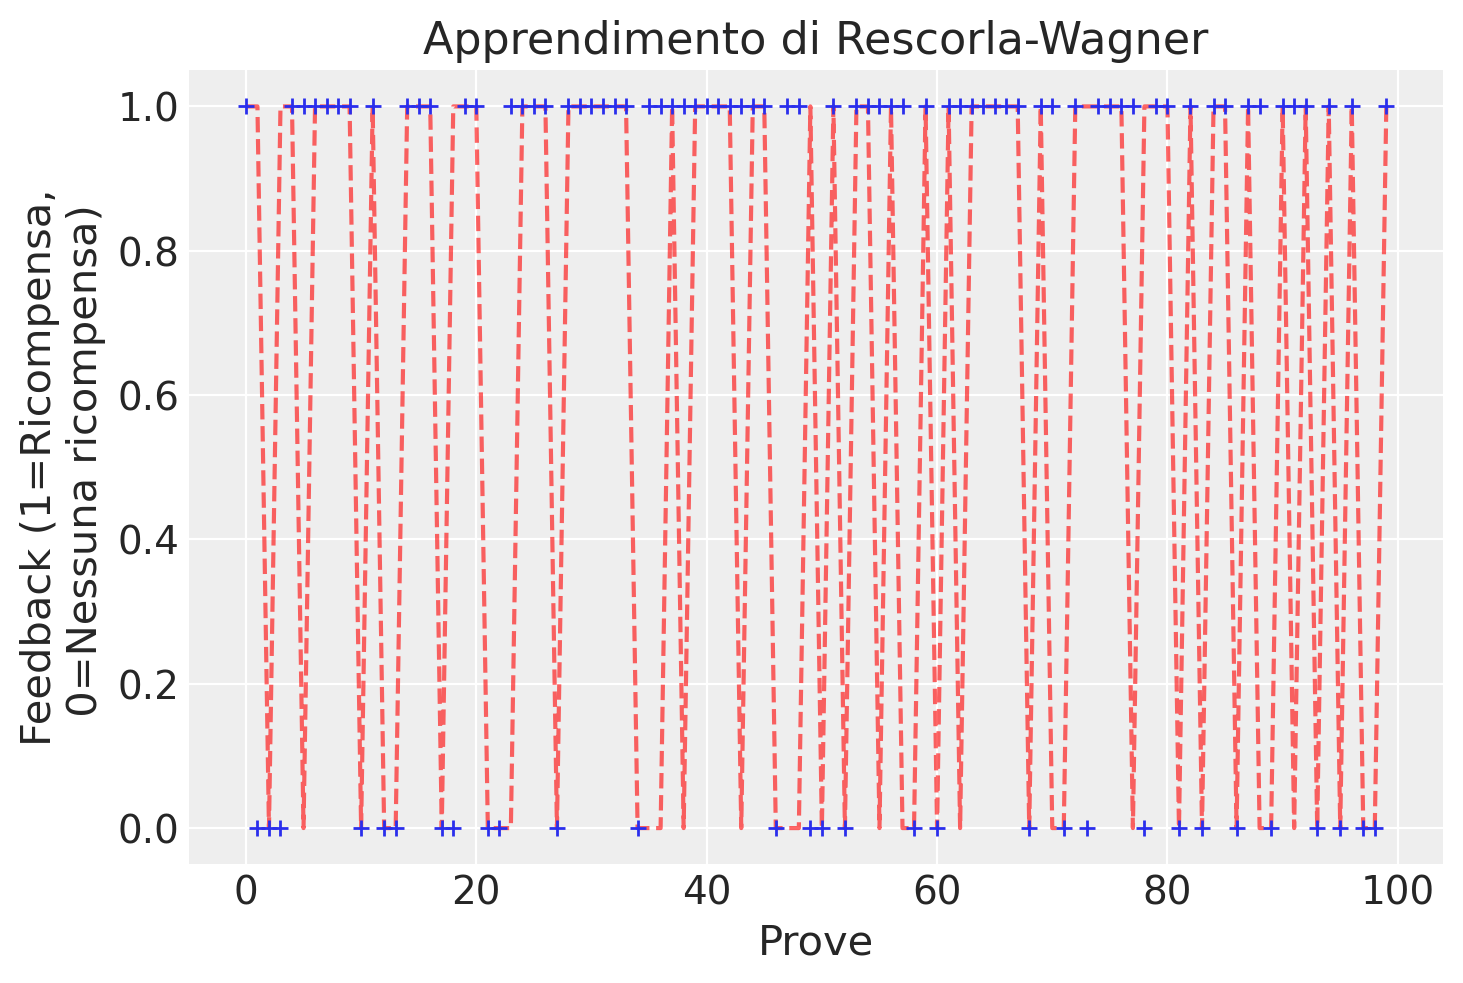

In [10]:
plt.plot(range(T), r, 'r--', alpha=.6)
plt.plot(range(T), c, '+', label='scelta')
plt.xlabel('Prove')
plt.ylabel('Feedback (1=Ricompensa,\n 0=Nessuna ricompensa)')
plt.title(f'Apprendimento di Rescorla-Wagner')
plt.show()


Come possiamo osservare, le scelte per la slot machine che produce meno ricompense diventano meno frequenti nel corso delle prove.

Possiamo anche rappresentare graficamente le aspettative di valore $Q$ delle due slot machine nel corso delle prove. 

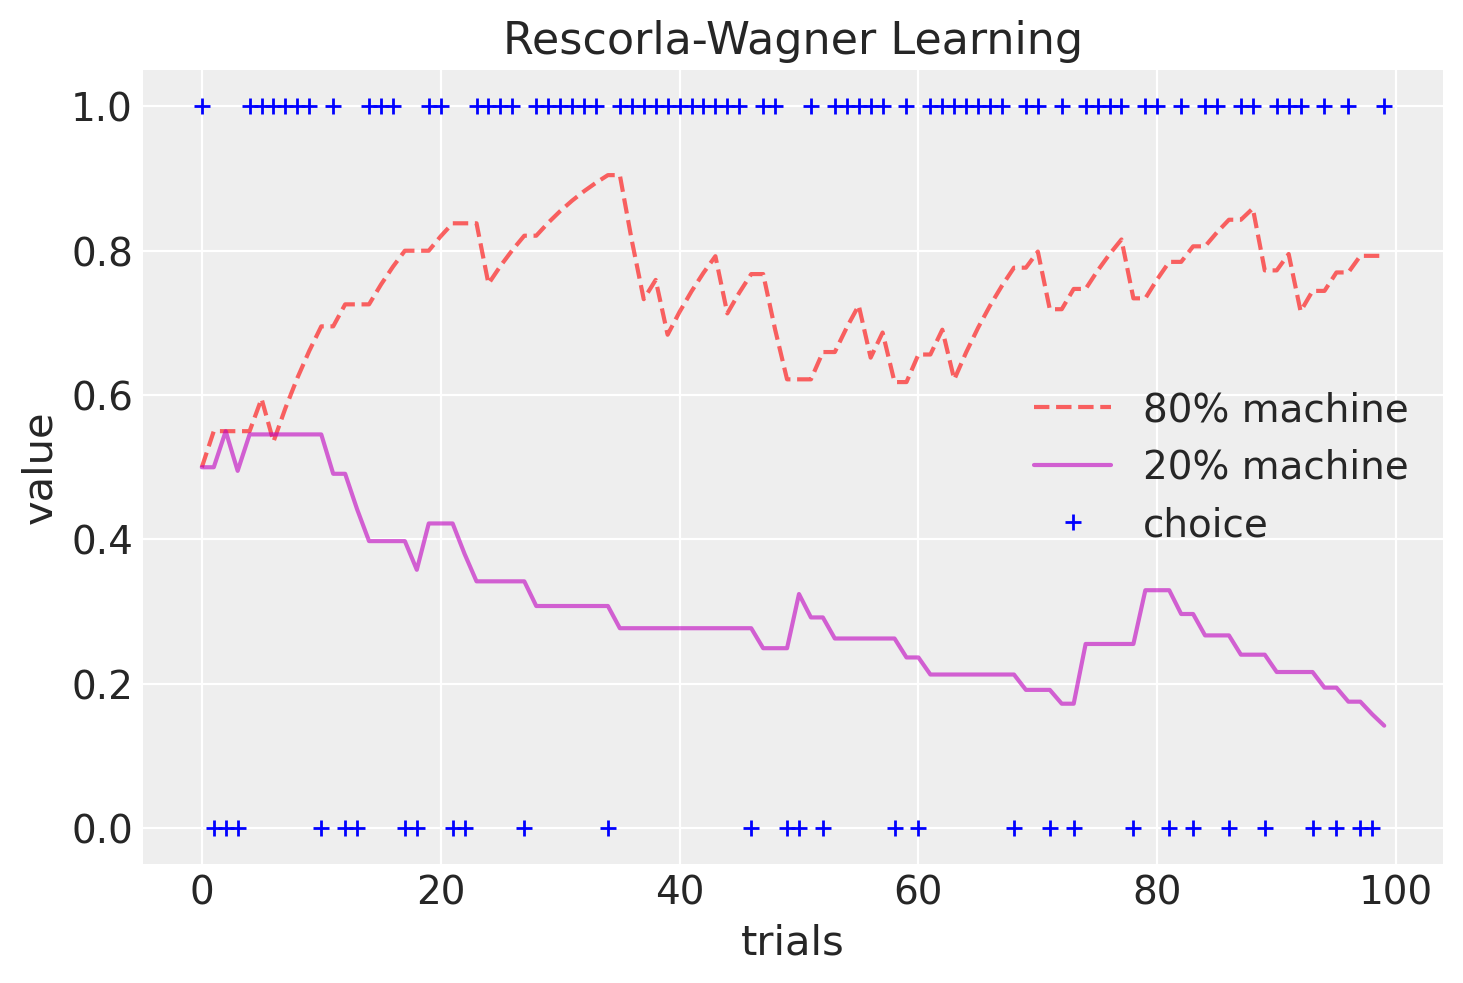

In [11]:
plt.plot(range(T), Q[1, :], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q[0, :], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

Si noti come nel corso delle prove i valori delle slot macchine convergano lentamente verso le probabilità di ricompensa (20% e 80%).

In sintesi, il modello di Rescorla-Wagner ci permette di simulare come le persone apprendono e prendono decisioni basate su ricompense. Utilizzando la regola di apprendimento ($\delta$-rule) e la regola decisionale softmax, possiamo vedere come le aspettative di valore e le scelte cambiano nel tempo in risposta alle ricompense ottenute.

## Adattamento del Modello

Dopo aver visto come funziona il modello di Rescorla-Wagner, il passo successivo è stimare i parametri del modello a partire dai dati osservati. Questo processo è fondamentale nella modellazione computazionale perché ci permette di capire quali valori dei parametri descrivono meglio il comportamento osservato. Esistono diversi metodi per stimare i parametri, ma ci concentreremo sull'approccio della *Massima Verosimiglianza*.

### La Massima Verosimiglianza

L'approccio della massima verosimiglianza cerca di trovare i valori dei parametri del modello che massimizzano la probabilità dei dati osservati. In altre parole, vogliamo trovare i parametri $(\alpha, \theta)$ che rendono i dati osservati $d_{1:T}$ più probabili secondo il modello Rescorla-Wagner.

### Calcolo del Logaritmo della Verosimiglianza

Massimizzare la verosimiglianza è spesso più facile se si lavora con il logaritmo della verosimiglianza, perché le moltiplicazioni di probabilità diventano somme. La log-verosimiglianza può essere espressa come:

$$ 
\log \mathcal{L} = \log p(d_{1:T} | (\alpha, \theta)_m, m) = \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

In questa equazione:
- $ \log \mathcal{L} $ è il logaritmo della verosimiglianza.
- $ p(d_{1:T} | (\alpha, \theta)_m, m) $ è la probabilità dei dati osservati dato il modello e i parametri.
- $ p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m) $ è la probabilità di ogni singola scelta $ c_t $ data la storia delle scelte e dei feedback fino al tempo $ t $ e i parametri del modello.

### Minimizzazione del Logaritmo Negativo della Verosimiglianza

In pratica, massimizzare la log-verosimiglianza è equivalente a minimizzare il logaritmo negativo della verosimiglianza. Questo ci porta alla seguente equazione:

$$ 
-\log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

Per applicare questa procedura al modello di Rescorla-Wagner, dobbiamo definire la funzione di log-verosimiglianza negativa specifica per il nostro modello. Questa funzione ci permette di calcolare quanto bene i parametri $\alpha$ e $\theta$ spiegano i dati osservati. Durante il processo di stima, l'obiettivo è minimizzare questa funzione per trovare i valori ottimali dei parametri.

### Esempio Pratico

Immaginiamo di avere dati osservati da un esperimento in cui un partecipante ha fatto 100 scelte tra due slot machine. Il nostro obiettivo è stimare i parametri $\alpha$ (tasso di apprendimento) e $\theta$ (temperatura) che meglio spiegano queste scelte. Per fare ciò, utilizziamo il metodo della massima verosimiglianza.

La seguente funzione `negll_RescorlaWagner` calcola il negativo della log-verosimiglianza per il modello di apprendimento di Rescorla-Wagner. Questo ci permette di capire quanto bene i parametri del modello ($\alpha$ e $\theta$) spiegano le scelte osservate. Ecco una spiegazione passo passo per capire come funziona questa funzione.

I parametri della Funzione sono:

- `params`: una lista che contiene i valori dei parametri $\alpha$ (tasso di apprendimento) e $\theta$ (temperatura).
- `c`: un array che contiene le scelte effettuate dal partecipante (0 o 1).
- `r`: un array che contiene le ricompense ricevute dopo ogni scelta (1 per ricompensa, 0 per nessuna ricompensa).

Esaminiamo ora il corpo della funzione.

1. **Inizializzazione dei Parametri**
    ```python
    alpha, theta = params
    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)
    ```

    - `alpha` e `theta` sono estratti dalla lista `params`.
    - `Q` è una lista che tiene traccia delle aspettative di valore per le due slot machine, inizializzate a 0.5.
    - `T` è il numero di scelte effettuate.
    - `choiceProb` è un array che memorizza la probabilità di ogni scelta effettuata.

2. **Calcolo delle Probabilità di Scelta e Aggiornamento dei Valori**
    ```python
    for t in range(T):
        p0 = np.exp(theta * Q[0]) / (np.exp(theta * Q[0]) + np.exp(theta * Q[1]))
        p = [p0, 1 - p0]
        choiceProb[t] = p[c[t]]
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta
    ```

    - **Calcolo delle Probabilità di Scelta**: 
        - `p0` è la probabilità di scegliere la prima slot machine.
        - `p` è una lista delle probabilità di scegliere ciascuna delle due slot machine.
        - `choiceProb[t]` memorizza la probabilità della scelta effettivamente fatta al tempo $ t $.
    - **Aggiornamento delle Aspettative di Valore**:
        - `delta` è la differenza tra la ricompensa effettiva `r[t]` e l'aspettativa di valore `Q[c[t]]` per la scelta fatta.
        - `Q[c[t]]` viene aggiornata secondo la regola di Rescorla-Wagner: il nuovo valore atteso è il vecchio valore atteso più una frazione (determinata da $\alpha$) dell'errore di previsione.

3. **Calcolo del Negativo della Log-Verosimiglianza**
    ```python
    negLL = -np.sum(np.log(choiceProb))
    return negLL
    ```

    - **Log-Verosimiglianza**:
        - `np.log(choiceProb)` calcola il logaritmo delle probabilità di scelta.
        - `np.sum(np.log(choiceProb))` somma questi logaritmi.
    - **Negativo della Log-Verosimiglianza**:
        - Il risultato è moltiplicato per -1 per ottenere il negativo della log-verosimiglianza, poiché nella stima dei parametri cerchiamo di minimizzare questa funzione.

In sintesi, la funzione `negll_RescorlaWagner`:
1. Calcola le probabilità di scelta basate sui parametri $\alpha$ e $\theta$.
2. Aggiorna le aspettative di valore in base alle scelte e alle ricompense osservate.
3. Calcola il negativo della log-verosimiglianza per valutare quanto bene i parametri spiegano i dati osservati.

Ecco la funzione completa con commenti per facilitarne la comprensione:

In [12]:
def negll_RescorlaWagner(params, c, r):
    alpha, theta = params
    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):
        # Calcola le probabilità di scelta per k = 2
        p0 = np.exp(theta * Q[0]) / (np.exp(theta * Q[0]) + np.exp(theta * Q[1]))
        # "p" è una lista di probabilità di scelta per le due opzioni disponibili
        p = [p0, 1 - p0]

        # Memorizza la probabilità della scelta effettuata
        choiceProb[t] = p[c[t]]

        # Aggiorna le aspettative di valore secondo la regola di Rescorla-Wagner
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    # Calcola il negativo della log-verosimiglianza
    negLL = -np.sum(np.log(choiceProb))

    return negLL

Simuliamo ora un set di dati.

In [13]:
# simulate choices from RW Model
alpha = .2
theta = 1.5
c, r, Q2 = simulate_RescorlaWagner([alpha, theta], T=T, mu=[.2, .8])

Per fare un esempio, valutiamo la log-verosimiglianza negativa per i dati simulati in corrispondenza dei valori `alpha` e `theta` indicati di seguito.

In [14]:
alpha_hat = 0.3
theta_hat = 2.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c, r)
print(alpha_hat, theta_hat, negLL)

0.3 2.5 66.03869612532785


In [15]:
alpha_hat = 0.2
theta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c, r)
print(alpha_hat, theta_hat, negLL)

0.2 1.5 62.32289709990049


Un metodo per trovare i parametri di massima verosimiglianza è effettuare una ricerca esaustiva su tutto lo spazio dei parametri. Questo significa selezionare i valori di `alpha` e `theta` per i quali la funzione `negLL` assume il valore più basso.

Per illustrare questo metodo, applichiamolo a un set di dati simulato. Per semplicità, assumiamo di conoscere il valore di $\theta$ e di dover trovare solo il valore di $\alpha$.

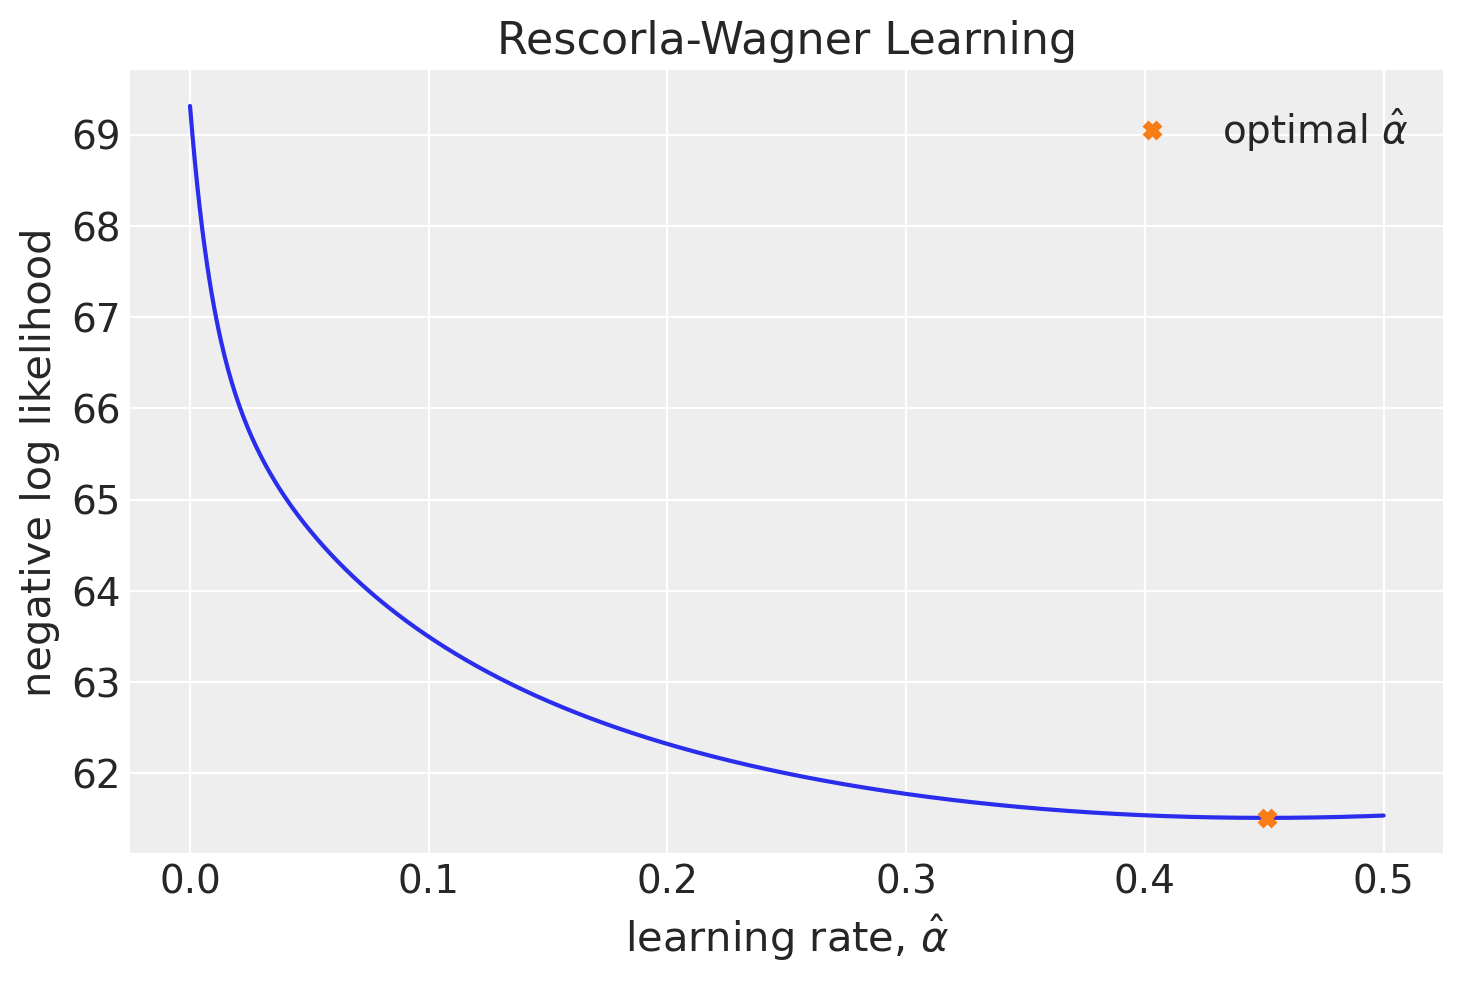

In [16]:
nLL = []
alpha_vals = np.linspace(0, 0.5, 1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, theta], c, r))

plt.figure()
plt.plot(alpha_vals, nLL, '-')
plt.plot(
    alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)],
    'X', label=r'optimal $\hat \alpha$'
)
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

### Validazione

Una volta stabilito un metodo per stimare i parametri del modello dai dati, dobbiamo valutare quanto accuratamente queste stime riflettano i veri valori dei parametri del modello. Per rispondere a questa domanda, possiamo condurre uno studio di simulazione.

I parametri della simulazione sono i seguenti.

In [17]:
T = 250
mu = [0.2, 0.8]
num_subjects = 20

Calcolimo i valori di massima verosimiglianza dei parametri `alpha` e `theta` usando la funzione `minimize` per minimizzare la funzione di log-verosimiglianza. Simuliamo i dati di un soggetto.

Specifichiamo poi le stime iniziali per i valori dei parametri e i valori margine delle possibili soluzioni. I risultati saranno salvati nell'oggetto `result`. Le stime dei due parametri si estraggono con `result.x`.

In [18]:
c, r, Q = simulate_RescorlaWagner([0.15, 1.5], T=T, mu=mu)

init_guess = (0.1, 0.1)

# minimize neg LL
result = minimize(
    negll_RescorlaWagner,
    init_guess,
    (c, r),
    bounds=((0, 1), (0, 10)),
)
print(result.x)

[0.15020303 1.02059312]


Simuliamo i dati per 500 soggetti, con 250 osservazioni ciascuno, utilizzando valori casuali di `alpha` e `theta`. Successivamente, eseguiamo la stima di massima verosimiglianza per i dati di ogni soggetto, inizializzando casualmente i parametri per ciascuno di essi. Infine, salviamo i risultati ottenuti nel DataFrame `df`. Ecco il codice corrispondente:

In [19]:
NREP = 500
df = pd.DataFrame(
    index=range(0, NREP), columns=["true_alpha", "alpha", "true_theta", "theta"]
)

# loop through subjects
for index in range(NREP):

    true_alpha = 0.95 * np.random.random()
    true_theta = 4.0 * np.random.random()

    c, r, Q = simulate_RescorlaWagner([true_alpha, true_theta], T=250, mu=mu)

    init_guess = (0.2 * np.random.random(), 1.0 * np.random.random())
    # minimize neg LL
    param_fits = minimize(
        negll_RescorlaWagner,
        init_guess,
        (c, r),
        bounds=((0, 1), (0, 10)),
    )

    # store in dataframe
    df.at[index, "true_alpha"] = true_alpha
    df.at[index, "true_theta"] = true_theta
    df.at[index, "alpha"] = param_fits.x[0]
    df.at[index, "theta"] = param_fits.x[1]

La figura successiva mostra una corrispondenza tra i valori stimati di alpha e i valori veri. È importante notare che la corrispondenza non è perfetta a causa della presenza di una componente di casualità nei dati. Inoltre, in alcuni casi si possono osservare valori stimati di alpha pari a 0 o 1, che corrispondono a risultati spurii dell'algoritmo. Il numero di risultati spurii aumenta con il diminuire del numero di osservazioni per ciascun soggetto.

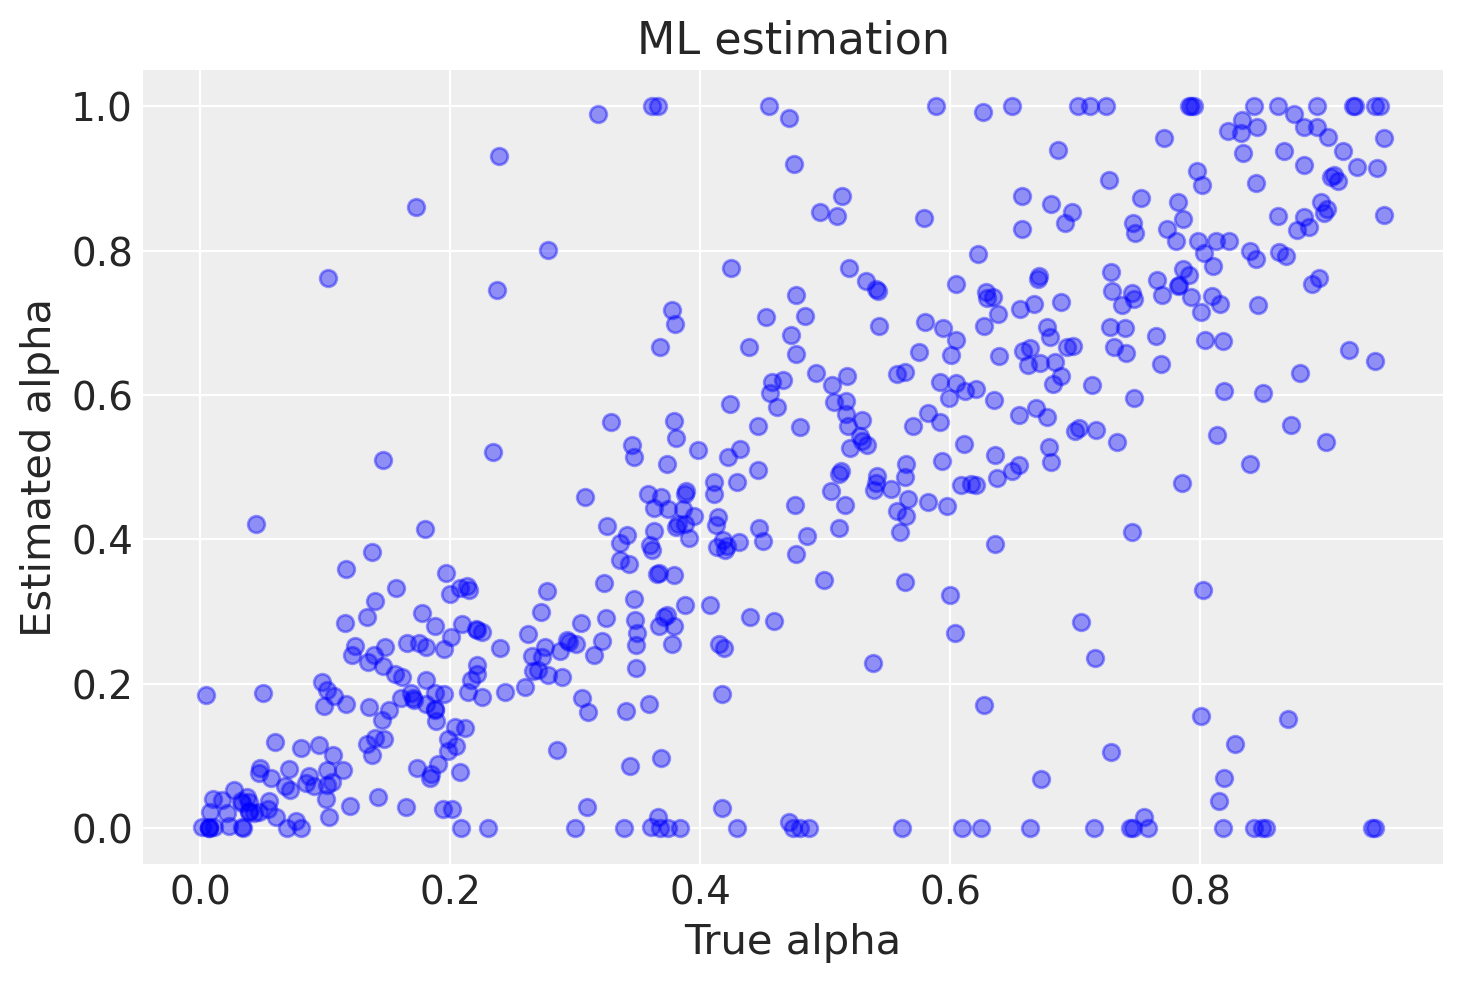

In [20]:
plt.plot(df.true_alpha, df.alpha, 'ob', alpha=.4)
plt.xlabel('True alpha')
plt.ylabel('Estimated alpha')
plt.title(f'ML estimation')
plt.show()

Un discorso analogo si può fare per theta, anche se in questo caso vi è una migliore corrispondenza tra i valori stimati e i valori veri.

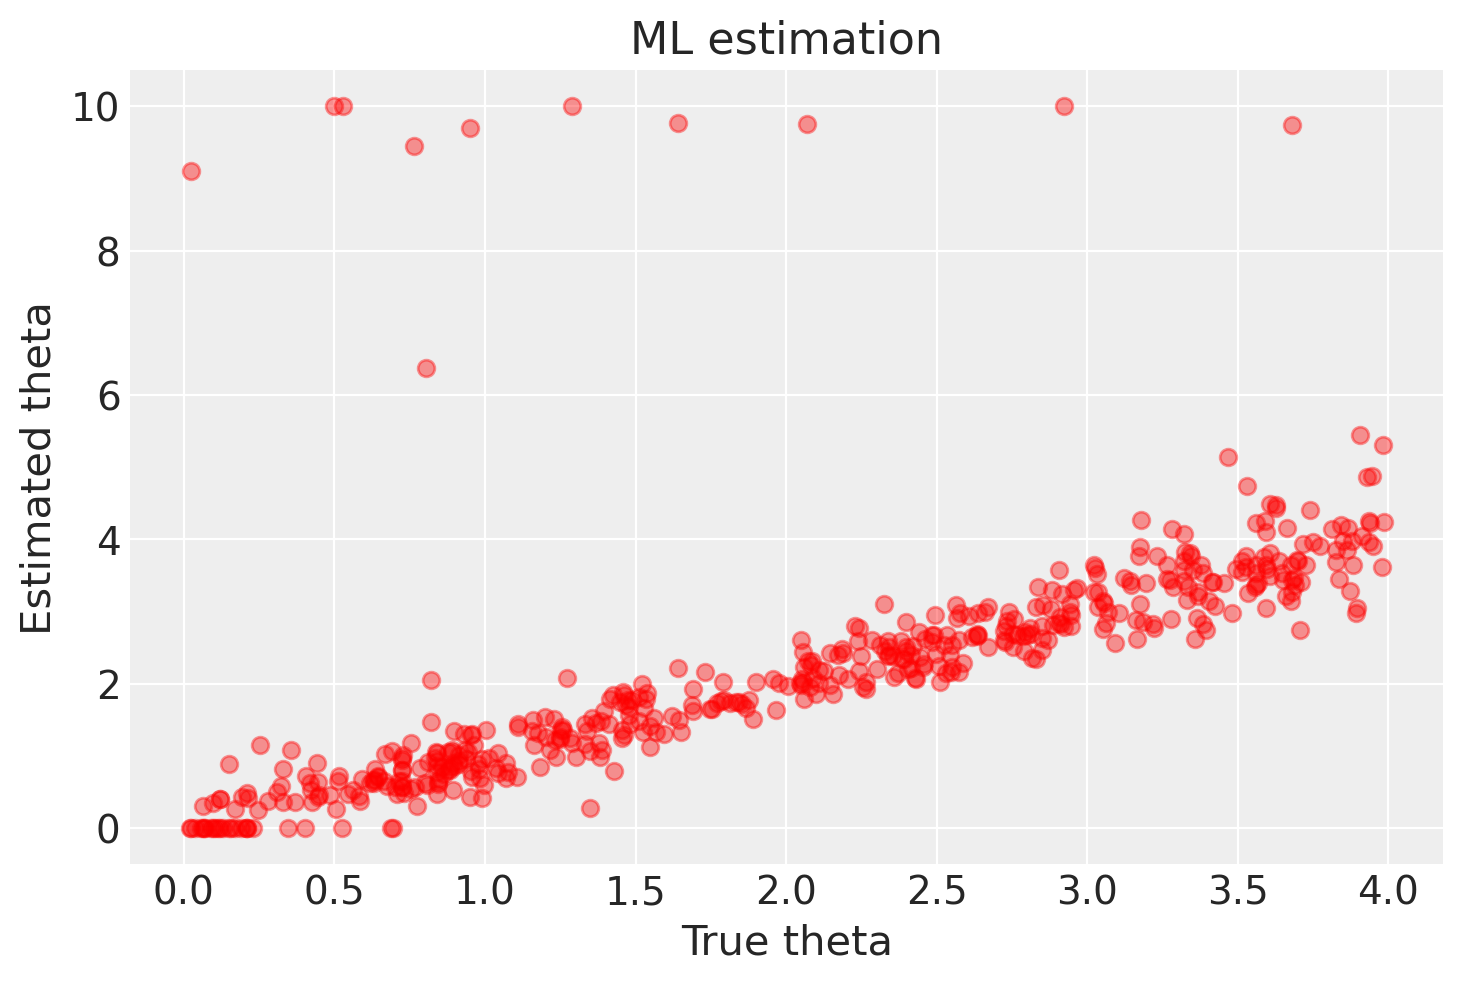

In [21]:
plt.plot(df.true_theta, df.theta, 'or', alpha=.4)
plt.xlabel('True theta')
plt.ylabel('Estimated theta')
plt.title(f'ML estimation')
plt.show()

In sintesi, possiamo affermare che il metodo della massima verosimiglianza è in grado di recuperare i valori simulati dei parametri $\alpha$ e $\theta$ del modello di Rescorla-Wagner, ma solo quando il numero di osservazioni per soggetto è considerevole. Tuttavia, è importante notare che questo metodo può produrre risultati imprecisi in determinate circostanze.

Esistono altri metodi di stima che offrono risultati migliori anche con un numero inferiore di osservazioni per soggetto. Tra questi, il metodo gerarchico bayesiano è ampiamente utilizzato nella pratica. Va precisato che l'obiettivo di questo tutorial era principalmente illustrare in modo semplice come sia possibile ottenere con buona accuratezza i parametri del modello di Rescorla-Wagner dai dati generati da una simulazione, considerando condizioni ottimali in cui i valori dei parametri del modello sono noti.

È importante sottolineare che, nella pratica, la stima dei parametri può essere un processo complesso e che l'accuratezza delle stime dipende da molteplici fattori, come la dimensione del campione e la natura dei dati osservati. Pertanto, è sempre consigliabile valutare attentamente i risultati e considerare l'utilizzo di approcci più sofisticati, come il metodo gerarchico bayesiano, per ottenere stime più affidabili dei parametri del modello.

## Stima con Stan

Consideriamo ora la stima dei parametri del modello Rescorla-Wagner usando un metodo bayesiano, ovvero mediante Stan. Iniziamo ad importare il codice Stan.

In [22]:
stan_file = os.path.join('../stan', 'rescorla_wagner.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=1> nTrials; // numero di tentativi
  array[nTrials] int<lower=1, upper=2> choice; // scelte effettuate (1 o 2)
  array[nTrials] real<lower=0, upper=1> reward; // ricompense ricevute (0 o 1)
}
transformed data {
  vector[2] initV; // valori iniziali per V
  initV = rep_vector(0.5, 2); // inizializzati a 0.5
}
parameters {
  real<lower=0, upper=1> alpha; // tasso di apprendimento
  real<lower=0> theta; // temperatura
}
model {
  vector[2] v; // valori attesi
  real delta; // errore di previsione
  
  // Priori
  alpha ~ beta(1, 1); // prior uniforme su [0, 1]
  theta ~ normal(0, 10); // prior normale con media 0 e deviazione standard 10
  
  v = initV;
  
  for (t in 1 : nTrials) {
    // Calcolo delle probabilità di scelta usando la funzione softmax con limitazione
    vector[2] logits;
    logits = theta * v;
    logits = fmin(logits, 20); // Limita i valori massimi per evitare overflow
    logits = fmax(logits, -20); // Limita i valori minimi per evitare underflow
 

### Sezione `data`
Questa sezione definisce i dati che vengono forniti al modello:

```stan
data {
  int<lower=1> nTrials; // numero di tentativi
  array[nTrials] int<lower=1, upper=2> choice; // scelte effettuate (1 o 2)
  array[nTrials] real<lower=0, upper=1> reward; // ricompense ricevute (0 o 1)
}
```

- `nTrials`: Il numero totale di tentativi o scelte effettuate dal partecipante.
- `choice`: Un array che contiene le scelte effettuate dal partecipante in ciascun tentativo (1 o 2).
- `reward`: Un array che contiene le ricompense ricevute per ciascun tentativo (0 o 1).

### Sezione `transformed data`
Questa sezione prepara alcuni dati iniziali trasformati per il modello:

```stan
transformed data {
  vector[2] initV; // valori iniziali per V
  initV = rep_vector(0.5, 2); // inizializzati a 0.5
}
```

- `initV`: Un vettore di lunghezza 2 che rappresenta i valori iniziali delle aspettative di ricompensa per le due opzioni, entrambi inizializzati a 0.5.

### Sezione `parameters`
Questa sezione definisce i parametri del modello che Stan cercherà di stimare:

```stan
parameters {
  real<lower=0, upper=1> alpha; // tasso di apprendimento
  real<lower=0> theta; // temperatura
}
```

- `alpha`: Il tasso di apprendimento, che determina quanto rapidamente il partecipante aggiorna le proprie aspettative. Questo valore è compreso tra 0 e 1.
- `theta`: La temperatura, che controlla il livello di esplorazione (quanto spesso il partecipante sceglie l'opzione con il valore atteso più alto rispetto a esplorare altre opzioni). Questo valore è positivo.

### Sezione `model`
Questa è la sezione principale che definisce come il modello effettua le stime e aggiorna i valori:

```stan
model {
  vector[2] v; // valori attesi
  real delta; // errore di previsione
  
  // Priori
  alpha ~ beta(1, 1); // prior uniforme su [0, 1]
  theta ~ normal(0, 10); // prior normale con media 0 e deviazione standard 10
  
  v = initV;
  
  for (t in 1 : nTrials) {
    // Calcolo delle probabilità di scelta usando la funzione softmax con limitazione
    vector[2] logits;
    logits = theta * v;
    logits = fmin(logits, 20); // Limita i valori massimi per evitare overflow
    logits = fmax(logits, -20); // Limita i valori minimi per evitare underflow
    
    choice[t] ~ categorical_logit(logits);
    
    // Errore di previsione
    delta = reward[t] - v[choice[t]];
    
    // Aggiornamento dei valori attesi (apprendimento)
    v[choice[t]] = v[choice[t]] + alpha * delta;
  }
}
```

- `v`: Un vettore che contiene i valori attesi delle ricompense per le due opzioni.
- `delta`: La differenza tra la ricompensa ricevuta e il valore atteso (errore di previsione).

#### Priori
Le distribuzioni prior definiscono le nostre convinzioni iniziali sui parametri prima di vedere i dati:

- `alpha ~ beta(1, 1)`: Una distribuzione beta uniforme per `alpha`, che assegna uguale probabilità a tutti i valori tra 0 e 1.
- `theta ~ normal(0, 10)`: Una distribuzione normale per `theta` con media 0 e deviazione standard 10.

#### Ciclo sui Tentativi
Per ogni tentativo, il modello:

1. **Calcola le probabilità di scelta** utilizzando la funzione softmax, limitando i valori per evitare overflow numerici:

   ```stan
   logits = theta * v;
   logits = fmin(logits, 20);
   logits = fmax(logits, -20);
   choice[t] ~ categorical_logit(logits);
   ```

   - `logits = theta * v;`: `logits` è un vettore che contiene i valori trasformati `theta * v`.
     - `theta` è la temperatura, che controlla quanto il partecipante esplora rispetto a sfruttare (scegliere l'opzione con il valore atteso più alto).
     - `v` sono i valori attesi delle ricompense per le due opzioni.
   - `logits = fmin(logits, 20);`: Questa funzione assicura che nessun valore in `logits` sia maggiore di 20. Se un valore è maggiore di 20, viene impostato a 20.
   - `logits = fmax(logits, -20);`: Questa funzione assicura che nessun valore in `logits` sia minore di -20. Se un valore è minore di -20, viene impostato a -20.
   - `choice[t] ~ categorical_logit(logits);`: `categorical_logit(logits)` è una distribuzione che assegna probabilità alle scelte (1 o 2) in base ai valori `logits`.

   **Motivazione**: Limitare i valori dei `logits` è importante per evitare problemi numerici (overflow) quando si calcolano le probabilità. Valori estremi di `theta * v` possono causare risultati non definiti o infiniti, quindi li limitiamo a un intervallo ragionevole (-20 a 20).

   **Funzionamento della Funzione `categorical_logit`**:
   - `categorical_logit(logits)` utilizza la funzione softmax per convertire i `logits` in probabilità.
   - La funzione softmax è definita come:
     $$
     \text{softmax}(z_i) = \frac{\exp(z_i)}{\sum_{j=1}^{K} \exp(z_j)}
     $$
     dove `z_i` sono i `logits` per ciascuna opzione.
   - Questa funzione garantisce che le probabilità siano comprese tra 0 e 1 e che la loro somma sia 1.

   **Esempio Pratico**:
   Supponiamo che `theta = 1` e i valori attesi siano `v = [0.3, 0.7]`. I `logits` sarebbero calcolati come:

   ```stan
   logits = theta * v; // logits = [1 * 0.3, 1 * 0.7] = [0.3, 0.7]
   logits = fmin(logits, 20); // nessun valore è maggiore di 20, quindi rimane [0.3, 0.7]
   logits = fmax(logits, -20); // nessun valore è minore di -20, quindi rimane [0.3, 0.7]
   ```

   Applicando la funzione softmax:

   $$
   \text{softmax}(0.3, 0.7) = \left( \frac{\exp(0.3)}{\exp(0.3) + \exp(0.7)}, \frac{\exp(0.7)}{\exp(0.3) + \exp(0.7)} \right)
   $$

   Calcolando le esponenziali e le probabilità:

   $$
   \exp(0.3) \approx 1.35, \quad \exp(0.7) \approx 2.01
   $$

   $$
   \text{softmax}(0.3, 0.7) \approx \left( \frac{1.35}{1.35 + 2.01}, \frac{2.01}{1.35 + 2.01} \right) = \left( 0.40, 0.60 \right)
   $$

   Quindi, le probabilità di scegliere l'opzione 1 e l'opzione 2 sono circa 0.40 e 0.60, rispettivamente. Il modello usa queste probabilità per determinare quale scelta viene effettivamente fatta al tempo `t`.

2. **Calcola l'errore di previsione** come la differenza tra la ricompensa ricevuta e il valore atteso:

   ```stan
   delta = reward[t] - v[choice[t]];
   ```

3. **Aggiorna i valori attesi** utilizzando l'errore di previsione e il tasso di apprendimento `alpha`:

   ```stan
   v[choice[t]] = v[choice[t]] + alpha * delta;
   ```

In sintesi,
- I `logits` sono valori calcolati come `theta * v` e limitati tra -20 e 20 per evitare problemi numerici.
- `categorical_logit(logits)` converte questi `logits` in probabilità utilizzando la funzione softmax.
- La scelta al tempo `t` (`choice[t]`) è modellata come una variabile categoriale con queste probabilità, riflettendo la probabilità che il partecipante scelga ciascuna delle opzioni.
- L'errore di previsione (`delta`) è calcolato come la differenza tra la ricompensa ricevuta e il valore atteso.
- I valori attesi (`v`) vengono aggiornati utilizzando l'errore di previsione e il tasso di apprendimento (`alpha`).

Questo modello Stan implementa il processo di apprendimento del modello di Rescorla-Wagner. Utilizza le scelte e le ricompense osservate per stimare i parametri `alpha` e `theta`, aggiornando le aspettative di ricompensa in base ai risultati di ogni tentativo.

### Inferenza

Compiliamo il modello Stan:

In [23]:
model = CmdStanModel(stan_file=stan_file)

Definiamo i parametri della simulazione:

In [24]:
params = [0.1, 2.5]  # alpha, theta
T = 300  # numero di tentativi
mu = [0.2, 0.8]  # probabilità di ricompensa per le due opzioni

Simuliamo i dati:

In [25]:
choices, rewards, Q_stored = simulate_RescorlaWagner(params, T, mu)

Prepariamo i dati per Stan. Si noti che abbiamo sommato 1 a `choices` per adattarsi agli indici di Stan che partono da 1.

In [26]:
c = choices + 1

stan_data = {
    'nTrials': T,
    'choice': c.tolist(),
    'reward': rewards.tolist()
}
print(stan_data)

{'nTrials': 300, 'choice': [2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2], 'reward': [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 

Eseguiamo il campionamento:

In [27]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei due parametri oggetto dell'inferenza insieme alle loro tracce (cioè i vettori dei campioni dei parametri $\alpha$ e $\theta$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

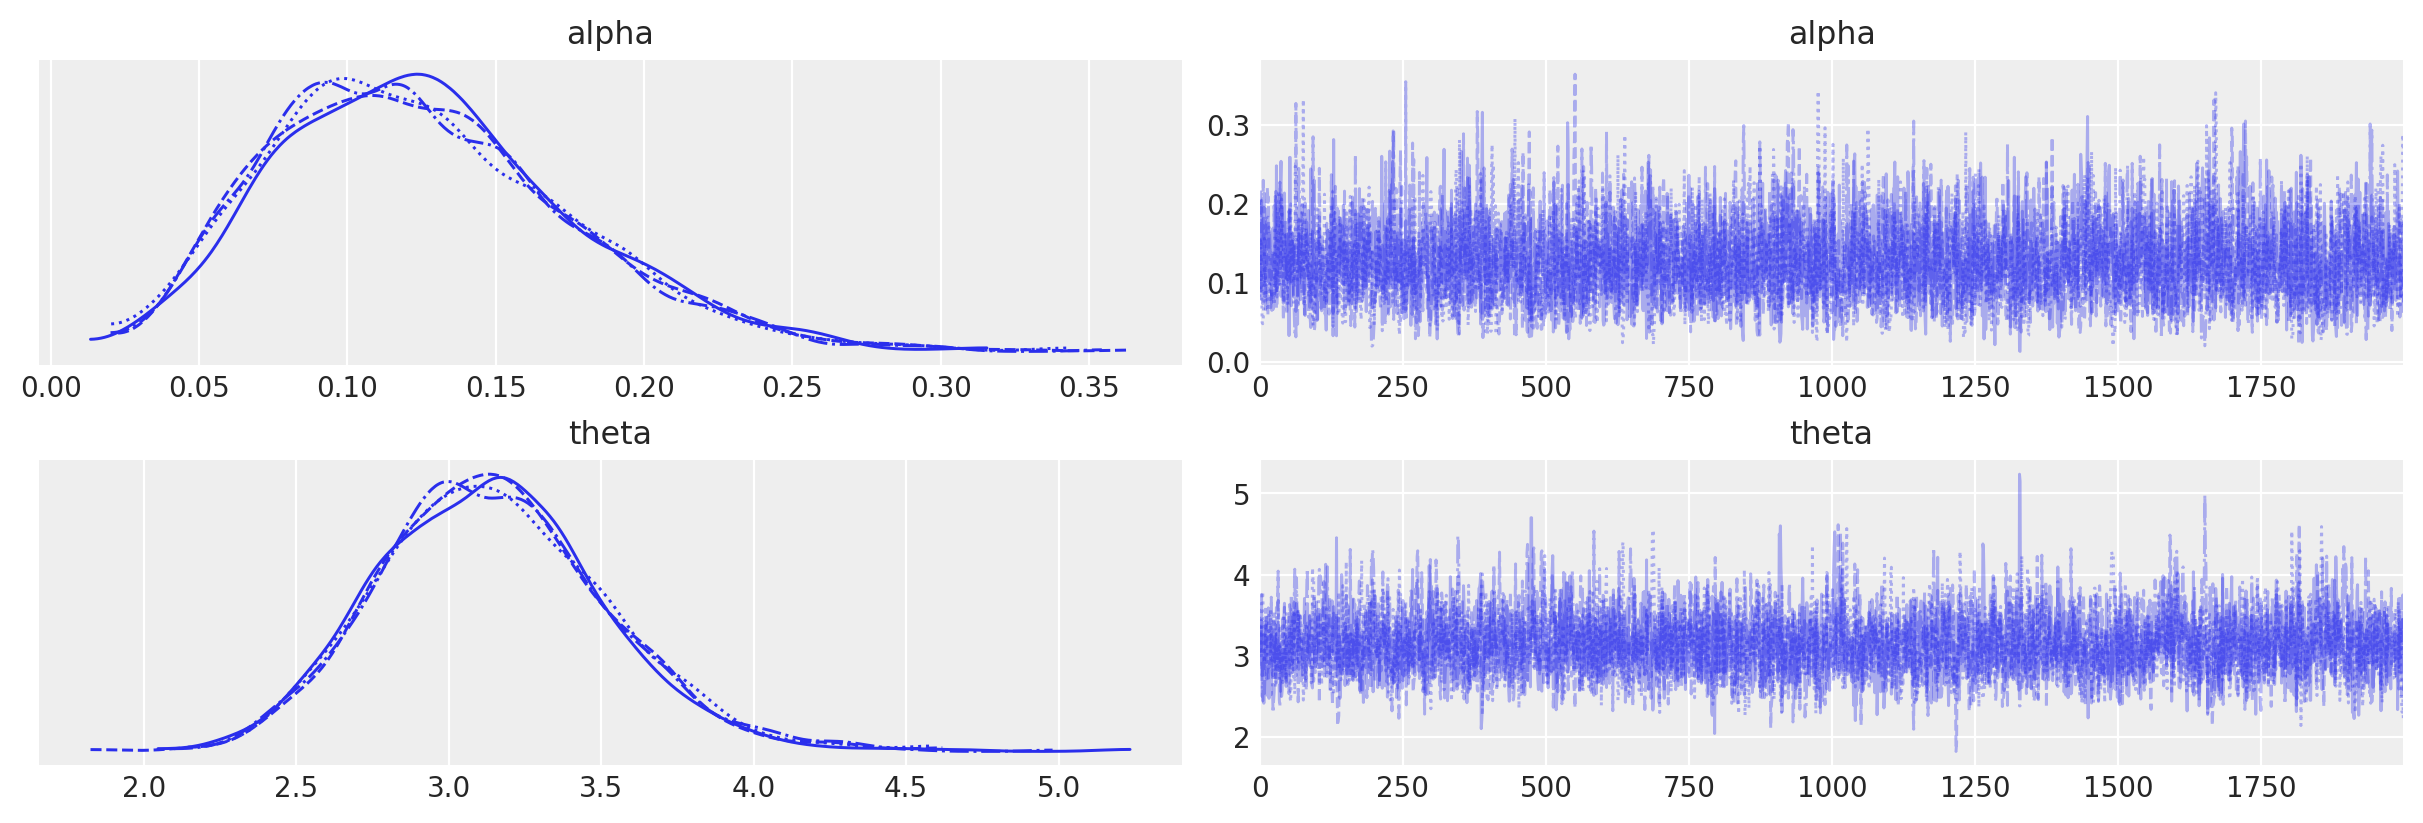

In [28]:
_ = az.plot_trace(trace)

### Interpretazione delle Stime dei Parametri

Utilizzando `az.summary(trace, hdi_prob=0.94, round_to=2)`, otteniamo un riassunto delle stime dei parametri del modello, che include la media, la deviazione standard, gli intervalli di credibilità (HDI) e altre statistiche diagnostiche:

In [29]:
az.summary(trace, hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.12,0.05,0.04,0.22,0.00,0.0,3221.75,3743.38,1.0
theta,3.14,0.37,2.44,3.81,0.01,0.0,3122.42,3749.75,1.0


Con 300 prove, le stime dei parametri fornite dal modello sono adeguate:
- **Intervallo di credibilità**: L'intervallo di credibilità al 94% (hdi_3% - hdi_97%) include il valore simulato del parametro. Questo significa che le stime del modello sono coerenti con i parametri originali usati nella simulazione.
- **Deviazione standard**: La deviazione standard della stima a posteriori è relativamente piccola, indicando che le stime sono precise.
- **r_hat**: I valori di `r_hat` sono vicini a 1, indicando che le catene di campionamento sono ben mescolate e hanno ottenuto la convergenza.

Questi risultati suggeriscono che il modello di apprendimento di Rescorla-Wagner ha stimato correttamente i parametri $\alpha$ e $\theta$ dai dati simulati.

## Informazioni sull'Ambiente di Sviluppo

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 23 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

logging   : 0.5.1.2
arviz     : 0.18.0
pandas    : 2.2.2
cmdstanpy : 1.2.3
matplotlib: 3.8.4
scipy     : 1.13.1
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3

